<h1><center><i><b><font color='red'>Predict Item Sales using Regression Techniques
          </font></b></i></center> </h1>

<h1><font color = 'red'><b>BY :</b></h1>

<h3><font color = 'darkblue'>1. Abduallah Hussien </h3>

<h3><font color = 'darkblue'>2. Sherif Essam</h3>

<h3><font color = 'darkblue'>3. Rawan Sayed</h3>

<h3><font color = 'darkblue'>4. Nouran Hany</h3>

<h3><font color = 'darkblue'>5. Aly Mamdouh</h3>

<h3><font color = 'darkblue'>6. Mahmoud Moustafa</h3>

## Imports

In [79]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,normalize, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
# importing machine learning models for prediction
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Read train and test csv files

In [80]:
df_train = pd.read_csv("train.csv",na_values=' ')
df_test = pd.read_csv("test.csv",na_values=' ')

## Print first 5 rows in train dataset

In [81]:
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Use .describe() to get some details of each numerical column in dataset

In [82]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
X2,4994.0,12.956536,4.658851,4.555,8.89500,12.80000,17.100000,21.350000
X4,6000.0,0.066333,0.051492,0.000,0.02703,0.05462,0.095154,0.328391
X6,6000.0,141.228200,62.540569,31.290,94.03765,143.19700,186.522050,266.888400
X8,6000.0,1997.840333,8.334412,1985.000,1987.00000,1999.00000,2004.000000,2009.000000
Y,6000.0,2188.996045,1701.705046,33.290,850.89240,1804.65090,3099.964800,12117.560000


## Use isna().sum() to check nulls count in each column

In [83]:
df_train.isna().sum()

X1        0
X2     1006
X3        0
X4        0
X5        0
X6        0
X7        0
X8        0
X9     1711
X10       0
X11       0
Y         0
dtype: int64

## Use .info() to know data type of each column in our dataset

In [84]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      6000 non-null   object 
 1   X2      4994 non-null   float64
 2   X3      6000 non-null   object 
 3   X4      6000 non-null   float64
 4   X5      6000 non-null   object 
 5   X6      6000 non-null   float64
 6   X7      6000 non-null   object 
 7   X8      6000 non-null   int64  
 8   X9      4289 non-null   object 
 9   X10     6000 non-null   object 
 10  X11     6000 non-null   object 
 11  Y       6000 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 562.6+ KB


In [85]:
categorical_features = ['X3', 'X5', 'X7', 'X8','X9', 'X10', 'X11']

In [86]:
numerical_features = ['X2', 'X4', 'X6','Y']

## Plot histogram of each numerical feature in dataset to help me check the skewness in each of those feature

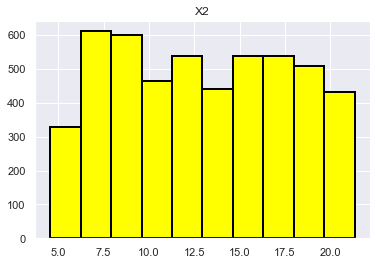

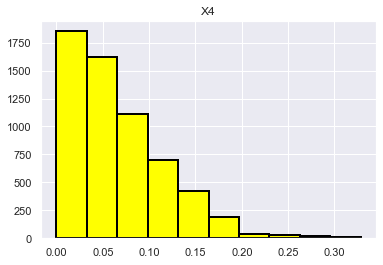

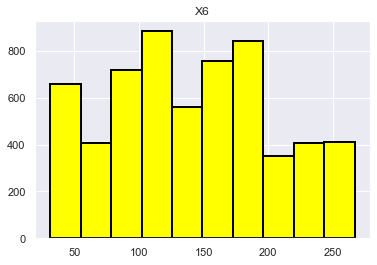

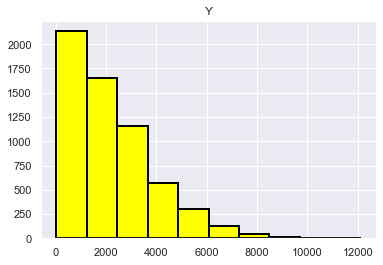

In [87]:
for i in numerical_features:
    plt.hist(df_train[i], color='yellow', edgecolor='black', linewidth=2)
    plt.title(i)
    plt.show()

## As we saw there is skewness in X4 and Y features the we will calculate the square root of each of them to have normal distribution

In [88]:
df_train['Y']=round(np.sqrt(df_train['Y']),1)
df_train['X4']=round(np.sqrt(df_train['X4']),1)

## Histograms after calculating the square root of each of X4 and Y

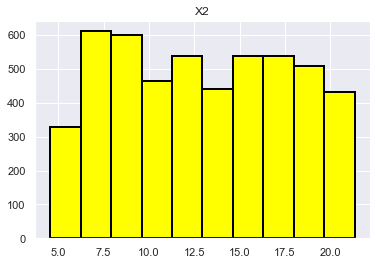

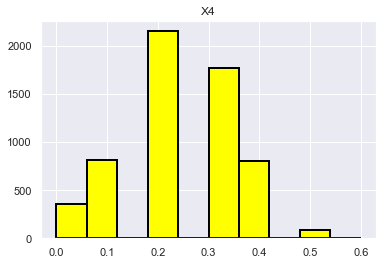

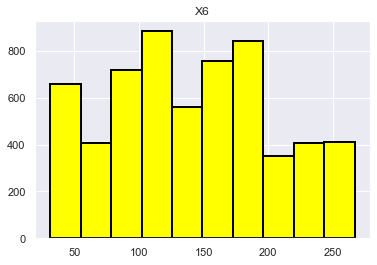

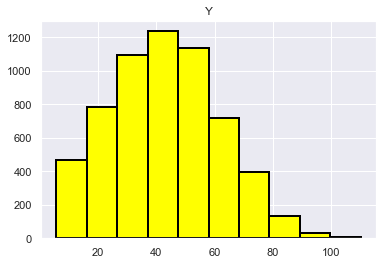

In [89]:
for i in numerical_features:
    plt.hist(df_train[i], color='yellow', edgecolor='black', linewidth=2)
    plt.title(i)
    plt.show()

## Plot boxplots of each numerical feature in dataset to help me check the outliers in each of those features

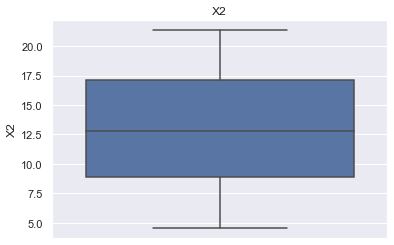

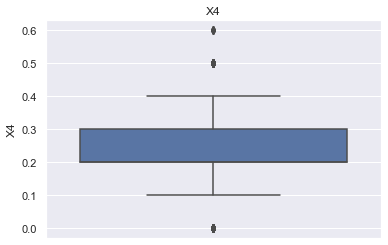

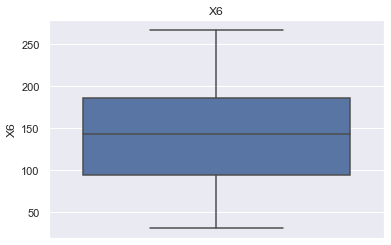

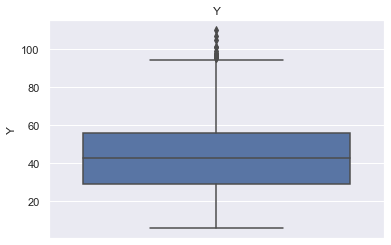

In [90]:
for i in numerical_features:
    sns.boxplot(y=df_train[i])
    plt.title(i)
    plt.show()

## As we saw there is outliers in X4 and Y features then we will make some calculations on those features to fix the problem of outliers

In [91]:
outliers_features = ['Y','X4']

In [92]:
for i in outliers_features:
    #Finding upper and lower limt for features in train set
    Inter_Quartile_Range = df_train[i].quantile(0.75) - df_train[i].quantile(0.25)

    lower_boundary = df_train[i].quantile(0.25) - (Inter_Quartile_Range * 1.5)
    upper_boundary = df_train[i].quantile(0.75) + (Inter_Quartile_Range * 1.5)
    df_train[i]= np.where(df_train[i] > upper_boundary, upper_boundary,np.where(df_train[i] < lower_boundary, lower_boundary,df_train[i]))

## Boxplots after applying calculations on each of X4 and Y features

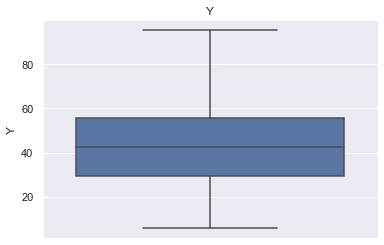

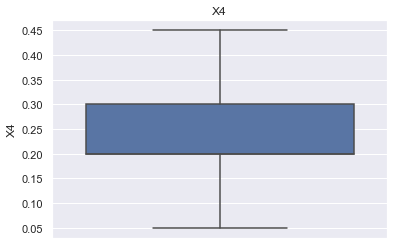

In [93]:
for i in outliers_features:
    sns.boxplot(y=df_train[i])
    plt.title(i)
    plt.show()

## Get the category that has the most count in X9 to fill the nulls with it  

In [94]:
print(df_train['X9'].mode())

0    Medium
dtype: object


In [95]:
df_train['X9'].fillna('Medium', inplace= True)

## Plot countplot on each categorical feature in dataset

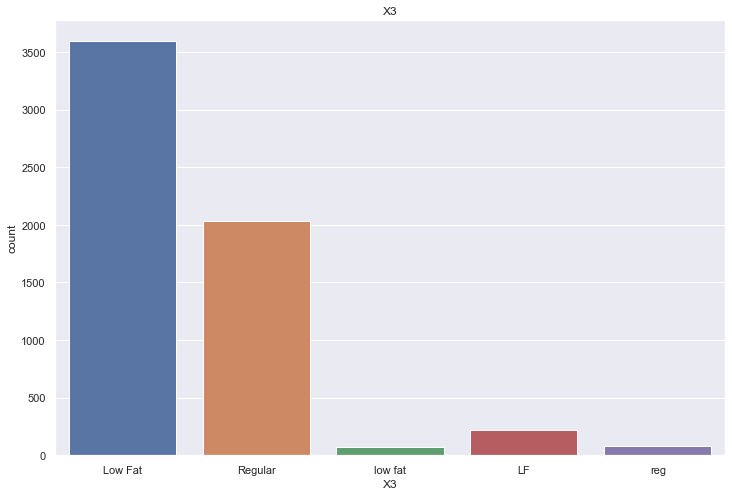

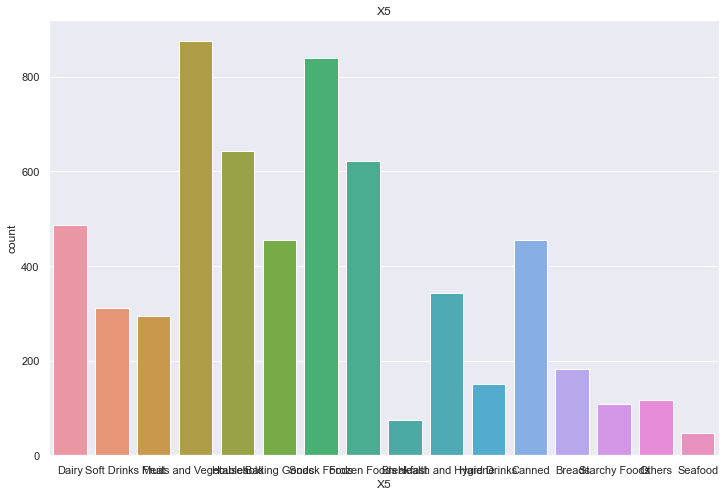

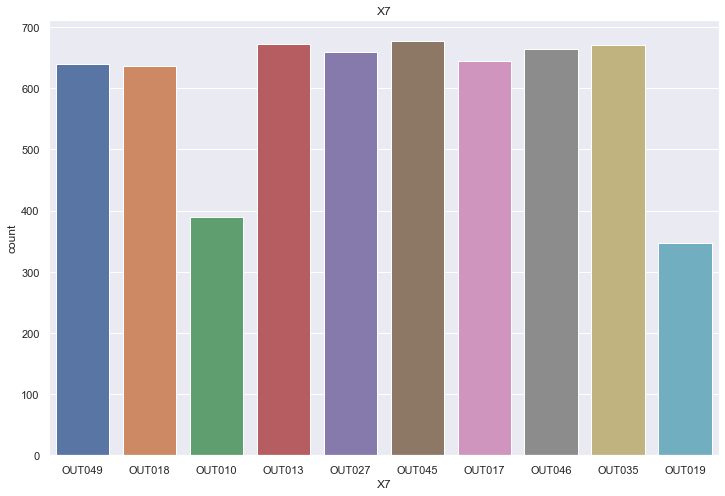

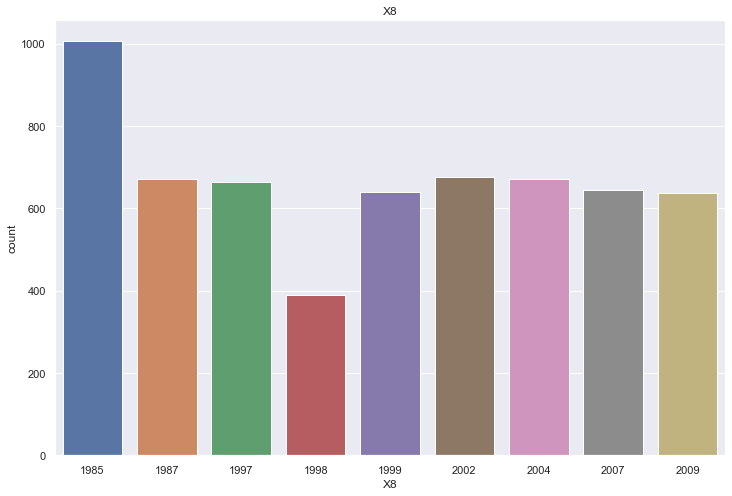

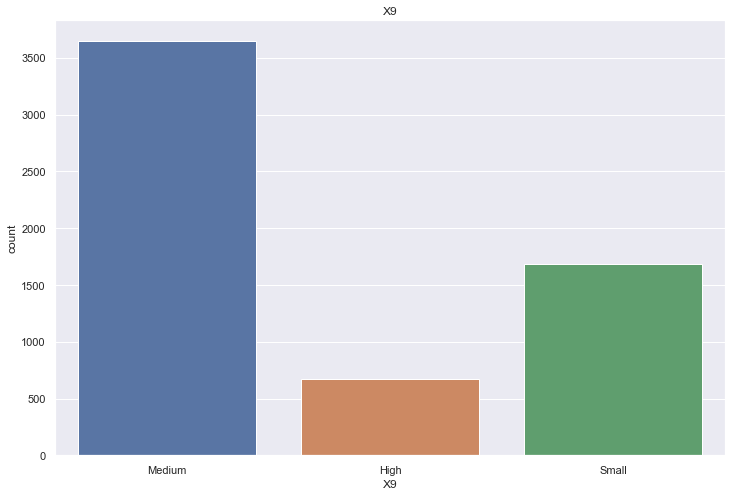

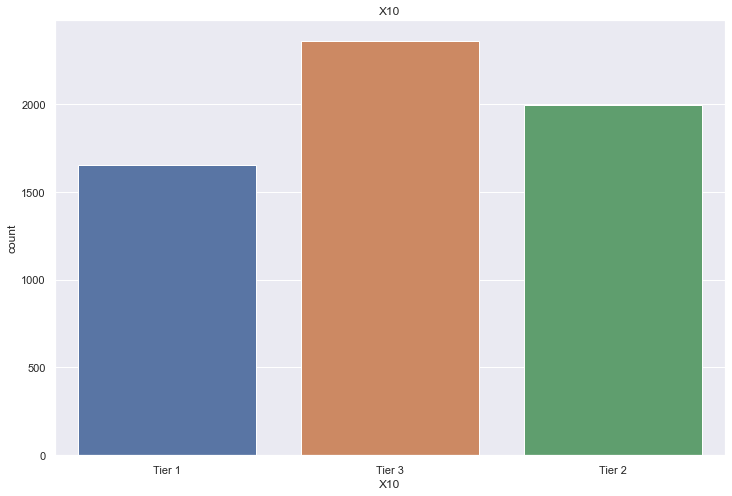

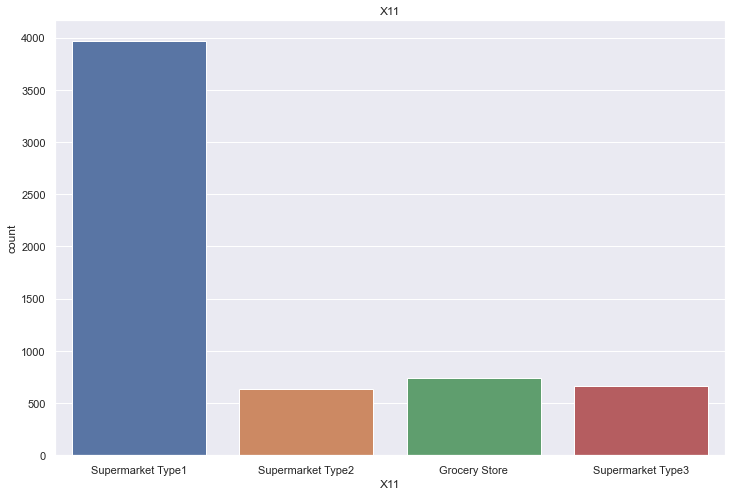

In [96]:
for i in categorical_features:
    sns.set(rc={"figure.figsize":(12, 8)})
    ax=sns.countplot(x=df_train[i], data=df_train);
    plt.title(i)
    plt.show()

## Use labelencoder to label each category from 0 to n category

In [97]:
le = preprocessing.LabelEncoder()
for i in categorical_features:
    df_train[i]= le.fit_transform(df_train[i])
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,FDA15,9.30,1,0.10,4,249.8092,9,4,1,0,1,61.1
1,DRC01,5.92,2,0.10,14,48.2692,3,8,1,2,2,21.1
2,FDN15,17.50,1,0.10,10,141.6180,9,4,1,0,1,45.8
3,FDX07,19.20,2,0.05,6,182.0950,0,3,1,2,0,27.1
4,NCD19,8.93,1,0.05,9,53.8614,1,1,0,2,1,31.5


In [98]:
df_train.isna().sum()

X1        0
X2     1006
X3        0
X4        0
X5        0
X6        0
X7        0
X8        0
X9        0
X10       0
X11       0
Y         0
dtype: int64

## Now we should fix the problem of nulls in X2 feature.
### There are many methods but i choose to make a linear regression model to predict these nulls according to the rest of features

In [99]:
imp = IterativeImputer(random_state=42,estimator = LinearRegression(), max_iter = 10, n_nearest_features = 2, skip_complete = True)
imp_df_train = imp.fit_transform(df_train.drop(["X1","Y"],axis = 1))
imp_df_train = pd.DataFrame(imp_df_train)
imp_df_train = pd.concat([imp_df_train,df_train[["X1","Y"]]], axis = 1)
imp_df_train.columns = ["X2","X3","X4","X5","X6","X7","X8","X9","X10","X11","X1","Y"]

imp_df_train

,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X1,Y
0,9.300,1.0,0.10,4.0,249.8092,9.0,4.0,1.0,0.0,1.0,FDA15,61.1
1,5.920,2.0,0.10,14.0,48.2692,3.0,8.0,1.0,2.0,2.0,DRC01,21.1
2,17.500,1.0,0.10,10.0,141.6180,9.0,4.0,1.0,0.0,1.0,FDN15,45.8
3,19.200,2.0,0.05,6.0,182.0950,0.0,3.0,1.0,2.0,0.0,FDX07,27.1
4,8.930,1.0,0.05,9.0,53.8614,1.0,1.0,0.0,2.0,1.0,NCD19,31.5
...,...,...,...,...,...,...,...,...,...,...,...,...
5995,20.600,1.0,0.20,6.0,94.7778,2.0,7.0,1.0,1.0,1.0,FDB32,36.3
5996,9.195,1.0,0.30,5.0,58.6246,9.0,4.0,1.0,0.0,1.0,FDJ16,29.5
5997,10.695,1.0,0.20,6.0,60.4536,7.0,5.0,1.0,1.0,1.0,FDJ32,13.6
5998,15.750,1.0,0.20,0.0,195.8452,6.0,6.0,2.0,1.0,1.0,FDO12,70.0


In [100]:
imp_df_train.isna().sum()

X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X1     0
Y      0
dtype: int64

In [101]:
#df_train.X2.fillna(np.mean(df_train.X2), inplace= True)
#df_test.X2.fillna(np.mean(df_test.X2), inplace= True)

## Check the corelations between our features as heatmap

<AxesSubplot:>

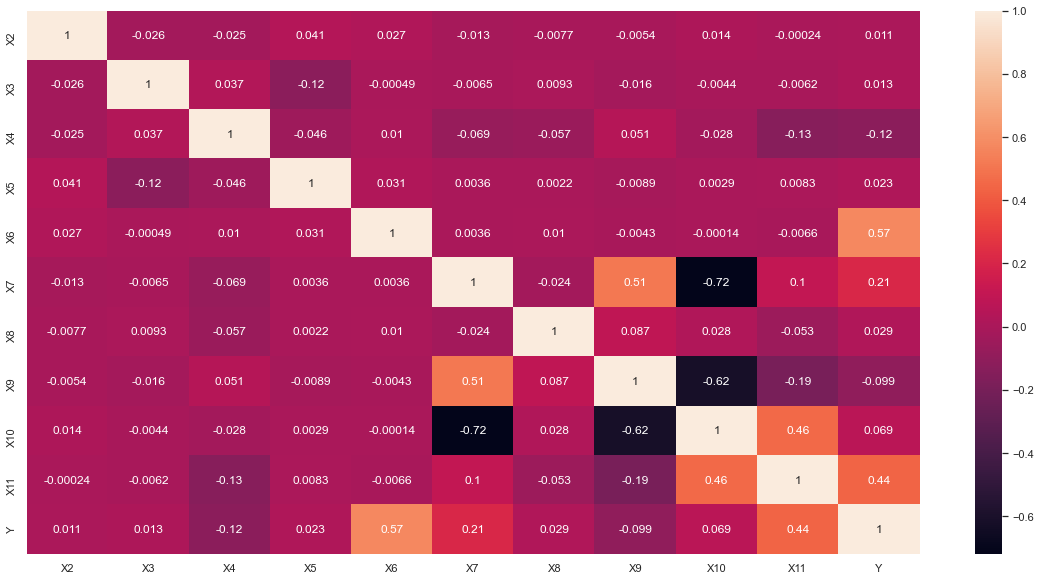

In [102]:
plt.figure(figsize=(20,10))
sns.heatmap(imp_df_train.corr(),annot=True)

## Dropping feature with bad corelations

In [103]:
#df_train = imp_df_train.drop(['X2','X3','X5','X8'],axis=1)
#df_test = imp_df_test.drop(['X2','X3','X5','X8'],axis=1)

In [104]:
df_train = imp_df_train

In [105]:
df_train.isna().sum()

X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X1     0
Y      0
dtype: int64

## Split dataset as X (features) and y (target) then apply StandardScaler as normalization technique

In [106]:
X = df_train.drop(['Y','X1'], axis=1)
y = df_train['Y']

In [107]:
s = StandardScaler()
X = s.fit_transform(X)
X = pd.DataFrame(X,columns=df_train.drop(['Y','X1'], axis=1).columns)
X

,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,-0.859489,-0.572015,-1.337201,-0.761685,1.736314,1.504304,0.077245,-0.279011,-1.382381,-0.256342
1,-1.654643,0.987316,-1.337201,1.612891,-1.486503,-0.609637,1.549752,-0.279011,1.090572,1.006425
2,1.069584,-0.572015,-1.337201,0.663061,0.006233,1.504304,0.077245,-0.279011,-1.382381,-0.256342
3,1.469514,0.987316,-1.823662,-0.286770,0.653499,-1.666608,-0.290881,-0.279011,1.090572,-1.519109
4,-0.946532,-0.572015,-1.823662,0.425603,-1.397078,-1.314284,-1.027135,-1.936501,1.090572,-0.256342
...,...,...,...,...,...,...,...,...,...,...
5995,1.798868,-0.572015,-0.364278,-0.286770,-0.742786,-0.961961,1.181625,-0.279011,-0.145904,-0.256342
5996,-0.884190,-0.572015,0.608644,-0.524227,-1.320910,1.504304,0.077245,-0.279011,-1.382381,-0.256342
5997,-0.531311,-0.572015,-0.364278,-0.286770,-1.291663,0.799657,0.445372,-0.279011,-0.145904,-0.256342
5998,0.657892,-0.572015,-0.364278,-1.711515,0.873378,0.447334,0.813498,1.378479,-0.145904,-0.256342


## Function for preprocessing as training data for any test data given

In [108]:
def preprocessingg(df_test):
    categorical_features = ['X3', 'X5', 'X7', 'X8','X9', 'X10', 'X11']
    numerical_features = ['X2', 'X4', 'X6','Y']
    df_test['X4']=round(np.sqrt(df_test['X4']),1)
    Inter_Quartile_Range = df_test['X4'].quantile(0.75) - df_test['X4'].quantile(0.25)
    lower_boundary = df_test['X4'].quantile(0.25) - (Inter_Quartile_Range * 1.5)
    upper_boundary = df_test['X4'].quantile(0.75) + (Inter_Quartile_Range * 1.5)
    df_test['X4']= np.where(df_test['X4'] > upper_boundary, upper_boundary,np.where(df_test['X4'] < lower_boundary,lower_boundary,df_test['X4']))
    df_test['X9'].fillna('Medium', inplace= True)
    le = preprocessing.LabelEncoder()
    for i in categorical_features:
        df_test[i]= le.fit_transform(df_test[i])
    imp_df_test = imp.transform(df_test.drop(["X1"],axis = 1))
    imp_df_test = pd.DataFrame(imp_df_test)
    imp_df_test = pd.concat([imp_df_test,df_test[["X1"]]], axis = 1)
    imp_df_test.columns = ["X2","X3","X4","X5","X6","X7","X8","X9","X10","X11","X1"]
    x_test = imp_df_test.drop(['X1'], axis=1)
    x_test = s.transform(x_test)
    x_test = pd.DataFrame(x_test,columns=df_test.drop(['X1'], axis=1).columns)

    return x_test

In [109]:
x_test = preprocessingg(df_test)
x_test.head()

,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,-0.018457,-0.572015,-1.337201,-1.236600,1.405675,0.095010,-1.395261,-0.279011,1.090572,2.269192
1,1.034296,0.987316,-0.364278,-0.999142,-0.880184,-1.314284,-1.027135,-1.936501,1.090572,-0.256342
2,-0.859489,-0.572015,0.608644,-0.524227,0.657244,-1.666608,-0.290881,-0.279011,1.090572,-1.519109
3,-1.468793,0.987316,-0.364278,-1.711515,-1.212338,1.504304,0.077245,-0.279011,-1.382381,-0.256342
4,0.975483,-0.572015,1.581566,-0.286770,-0.507546,-0.961961,1.181625,-0.279011,-0.145904,-0.256342


## Splitting dataset into train and validation (80% and 20%)

In [110]:
from sklearn.model_selection import train_test_split  

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size= 0.1, random_state=1)  

np.shape(y_train)

(5400,)

In [111]:
model = MLPRegressor()
# training all the model on the training dataset
model.fit(x_train, y_train)
# predicting the output on the validation dataset
pred = model.predict(x_test)
y_pred = model.predict(x_train)
y_pred2 = model.predict(x_val)

# printing the root mean squared error between real value and predicted value
print('Accuracy of model on train set: {:.0f} %'.format(model.score(x_train, y_train)*100))
print('Accuracy of model on test set: {:.0f} %'.format(model.score(x_val, y_val)*100))
print('mse of model on train set: {:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))
print('mse of model on test set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred2))))

Accuracy of model on train set: 69 %
Accuracy of model on test set: 66 %
mse of model on train set: 10.21
mse of model on test set: 10.58


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Function to apply techniques of regression on our dataset and display accuracies and mean square errors on train and test sets, then sorting those techniques descendingly according to accuracy on test set, then showing in dataframe

In [75]:
def data_training(x_train, x_val, y_train, y_val):

    models = []
    models.append(('RF',RandomForestRegressor()))
    models.append(('GBM',GradientBoostingRegressor()))
    models.append(('LightGBM',lgb.LGBMRegressor()))
    models.append(('LR',LinearRegression()))
    models.append(('Catboost',CatBoostRegressor(silent = True)))
    models.append(('MLP',MLPRegressor()))
    models.append(('SVM',SVR()))
    models.append(('Xgb',xgb.XGBRegressor()))

    df_result = pd.DataFrame(columns=["model","Accuracy of model on train set","Accuracy of model on test set","mse of model on train set","mse of model on test set"])
    index = 0
    for name,model in models:
        model.fit(x_train,y_train)
        y_pred = model.predict(x_train)
        y_pred2 = model.predict(x_val)
        train_score = model.score(x_train, y_train)
        test_score = model.score(x_val, y_val)
        train_mse = np.sqrt(mean_squared_error(y_train, y_pred))
        test_mse = np.sqrt(mean_squared_error(y_val, y_pred2))
        df_result.at[index,['model','Accuracy of model on train set','Accuracy of model on test set',"mse of model on train set","mse of model on test set"]] = [name,train_score,test_score,train_mse,test_mse]
        index += 1
    return df_result.sort_values("Accuracy of model on test set",ascending=False)

In [76]:
dt = data_training(x_train, x_val, y_train, y_val)
dt

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,Accuracy of model on train set,Accuracy of model on test set,mse of model on train set,mse of model on test set
1,GBM,0.704828,0.663184,9.899565,10.727342
5,MLP,0.688523,0.662064,10.169318,10.74517
4,Catboost,0.807714,0.64147,7.990108,11.067739
2,LightGBM,0.776578,0.640709,8.612753,11.079477
6,SVM,0.662231,0.638867,10.58982,11.107841
0,RF,0.949588,0.624961,4.091141,11.319683
7,Xgb,0.885614,0.60945,6.162608,11.551385
3,LR,0.575092,0.565502,11.87753,12.184003


In [112]:
df_test['row_id'] = np.arange(0,2523)

df_test['Y'] = pred
df_test['Y']=round(df_test['Y']**2,1)

df_test.drop(df_test.iloc[:,0:-2], inplace= True, axis = 1)
df_test.to_csv('draft.csv', index=False)

In [113]:
df_test

,row_id,Y
0,0,5859.9
1,1,1214.6
2,2,365.1
3,3,976.8
4,4,1652.6
...,...,...
2518,2518,3126.7
2519,2519,1685.0
2520,2520,1273.6
2521,2521,1389.3
